In [2]:
## Import the packages we will use
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Lesson 1 : Demonstration

This first example follows Chapter 4, section 3 of Richard McElreath's book _[Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/)_.

The task is understand height in a population, in this case using data about the !Kung San people. Anthropologist Nancy Howell conducted interviews with the !Kung San and collected the data used here.

The data are available in the github repository for the book: https://github.com/rmcelreath/rethinking/blob/master/data/Howell1.csv

In [5]:
# Read some data into a frame
# A frame is like an table in a spreadsheet. 
# It contains columns (which usually have names) and rows (which can be indexed by number, 
# but may also have names)
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', sep=";")
df.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

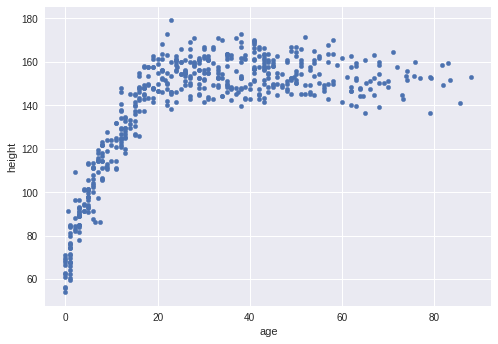

In [6]:
# Graph the data -- let's look at height vs. age
df.plot.scatter(x='age', y='height')

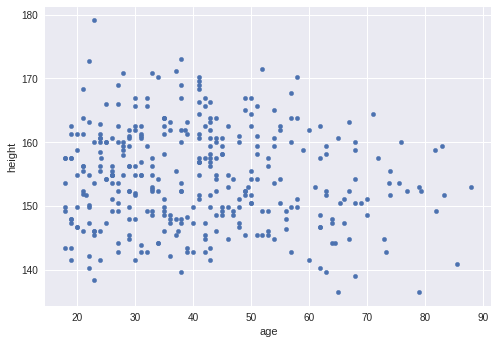

In [7]:
# Filter to adults, since height and age are correlated in children
adults_df = df[df['age'] >= 18]
# Look at height vs. age again
adults_df.plot.scatter(x='age', y='height')

In [8]:
# Print out how many rows are in each frame
len(df), len(adults_df)

(544, 352)

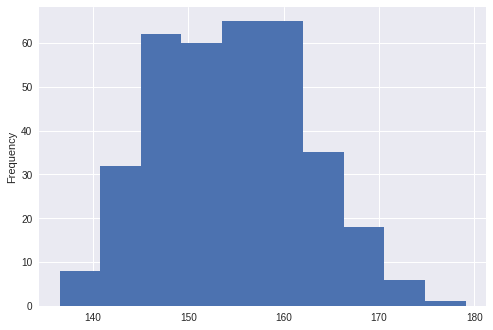

In [9]:
# Let's look at how the data are distributed
adults_df['height'].plot.hist()

In [10]:
# Split data in to male and female
# -- first add in a sex column to make it less confusing
df['sex'] = df.apply(lambda row: 'Male' if row['male'] == 1 else 'Female', axis=1)
# -- re-apply the filter, since we modified the data
adults_df = df[df['age'] >= 18]
adults_df.head()

height     weight   age  male     sex
0  151.765  47.825606  63.0     1    Male
1  139.700  36.485807  63.0     0  Female
2  136.525  31.864838  65.0     0  Female
3  156.845  53.041915  41.0     1    Male
4  145.415  41.276872  51.0     0  Female

In [11]:
# Let's summarize the data
adults_df[['age', 'height', 'weight']].describe()

age      height      weight
count  352.000000  352.000000  352.000000
mean    41.138494  154.597093   44.990486
std     15.967855    7.742332    6.456708
min     18.000000  136.525000   31.071052
25%     28.000000  148.590000   40.256290
50%     39.000000  154.305000   44.792210
75%     51.000000  160.655000   49.292693
max     88.000000  179.070000   62.992589

In [12]:
# Let's look at the data broken down by sex
adults_df[['age', 'height', 'weight', 'sex']].groupby('sex').describe()

age      height      weight
sex                                             
Female count  187.000000  187.000000  187.000000
       mean    40.712299  149.513519   41.814190
       std     16.219897    5.084577    5.387917
       min     18.000000  136.525000   31.071052
       25%     27.000000  146.050000   37.931631
       50%     38.000000  149.860000   41.645416
       75%     51.000000  153.035000   45.146579
       max     85.600000  162.560000   56.755699
Male   count  165.000000  165.000000  165.000000
       mean    41.621515  160.358476   48.590287
       std     15.712552    6.009177    5.635564
       min     18.000000  139.700000   31.524644
       25%     29.000000  157.480000   45.217453
       50%     41.000000  160.655000   48.420946
       75%     50.000000  163.830000   52.219779
       max     88.000000  179.070000   62.992589

In [13]:
# Let's focus on the means and std
summary_df = adults_df[['age', 'height', 'weight', 'sex']].groupby('sex').describe()
summary_df.loc[(slice(None),['mean', 'std']), :]

age      height     weight
sex                                          
Female mean  40.712299  149.513519  41.814190
       std   16.219897    5.084577   5.387917
Male   mean  41.621515  160.358476  48.590287
       std   15.712552    6.009177   5.635564

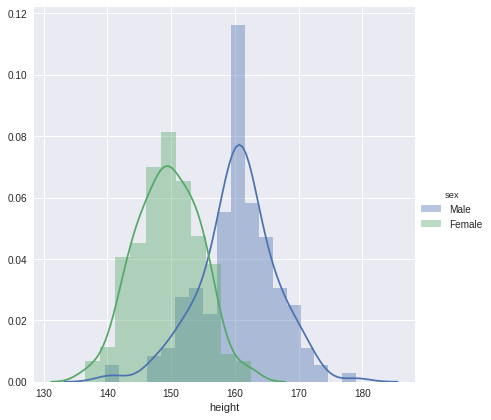

In [14]:
# Let's look at this visually -- plot height broken down by sex
g = sns.FacetGrid(adults_df, hue='sex', size=6)
g.map(sns.distplot, "height")
g.add_legend()

In [15]:
# Actually, let's look at everything
# -- first, get rid of the male column, it's redundant and confusing
del adults_df['male']
adults_df.head()

height     weight   age     sex
0  151.765  47.825606  63.0    Male
1  139.700  36.485807  63.0  Female
2  136.525  31.864838  65.0  Female
3  156.845  53.041915  41.0    Male
4  145.415  41.276872  51.0  Female

In [16]:
# -- now flatten the data -- very confusing, it will be explained later
flat_df = adults_df.set_index('sex', append=True)
flat_df = flat_df.stack().reset_index([1, 2])
flat_df.columns = ['sex', 'measurement', 'value']
flat_df.head()

sex measurement       value
0    Male      height  151.765000
0    Male      weight   47.825606
0    Male         age   63.000000
1  Female      height  139.700000
1  Female      weight   36.485807

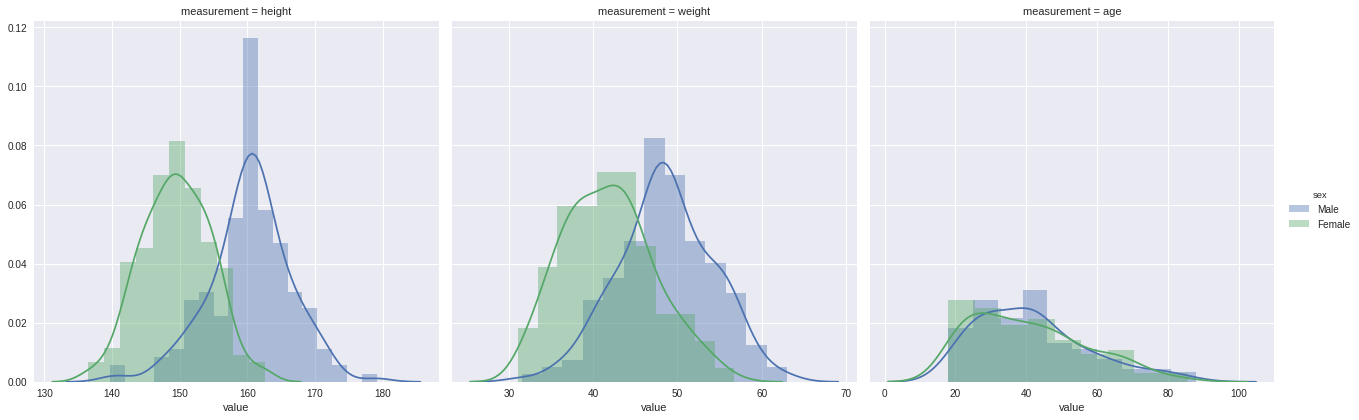

In [17]:
# Plot!
g = sns.FacetGrid(flat_df, col='measurement', hue='sex', size=6, sharex=False)
g.map(sns.distplot, "value")
g.add_legend()

# Lesson 2: Details

What just happened!? Let's take a deeper look at what was done above.

## Key abstractions in Pandas
### Series

Series are one-dimensional arrays, which can also be "labelled" - have labeled indices. You've probably encountered this already. Let's create a dummy dataframe to illustrate this point.

In [5]:
dummy_df = pd.DataFrame([['a', 'b'], ['c','d']])
dummy_df

0  1
0  a  b
1  c  d

A column of a dataframe is a series.

In [8]:
type(dummy_df[0])

pandas.core.series.Series

As is the row of a datafrmae.

In [9]:
type(dummy_df.loc[0])

pandas.core.series.Series

One can also construct a series from a list.

In [10]:
pd.Series([1,2,3,4])

0    1
1    2
2    3
3    4
dtype: int64

Even better than a normal 1-D array, you can label the axis.

In [11]:
pd.Series([1,2,3,4], index=['one', 'two', 'three', 'four'])

one      1
two      2
three    3
four     4
dtype: int64

### Dataframes

One central abstraction in pandas is the DataFrame, which is similar to a data frame in R &mdash; that is, basically a spreadsheet. It is made up of columns, which are usually names, and rows, which may be named or just accessed by index.

Pandas is designed to be fast and efficient, so the table isn't necessarily stored the way you think it is internally. In particular, data is stored in columns, and each column is a pandas Series, which itself builds on numpy arrays, not native Python arrays.

Pandas can read data in many formats. CSV and JSON are common ones to use. You can control many aspects about how the data is read. Below, you see that the structure of the file is csv-like, but instead the ';' is used as the column separator. This is not a problem. Pandas can also handle different file encodings (UTF-8 is the default), etc. 

### Reading in data from a file

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv', sep=";")
df.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

### Constructing a dataframe

If you were already manipulating data in python and had them as series or pandas object, you could construct a dataframe from pandas series objects.

In [13]:
col1 = pd.Series([0,1,2,3])
col2 = pd.Series([4,5,6,7])

pd.DataFrame({"col1": col1, "col2": col2})

col1  col2
0     0     4
1     1     5
2     2     6
3     3     7

## Basic frame manipulations — Accessing columns, rows, elements

In [19]:
df['height'].head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

In many cases, columns of a frame can be accessed like an array. The result is a pandas Series object, which, as you see, has a name, index, and type.

### Aside — why all the calls to 'head()'?

Series and frames can be very large. The methods head() and tail() can be used get a few of the first and last rows, respectively. By default, first/last 5 rows are returned. It's used here to limit output to a small number of rows, since there is no need to see the whole table.

### Accessing a dataframe using `loc`
The method `loc` allows you to access the dataframe using the "label" of the index. 

If you look at the dataframe we read in at the beginning of the lesson, the row labels are actually numbers, so you can access a single row using what's functionally an index.

In [6]:
df.loc[0]

height    151.765000
weight     47.825606
age        63.000000
male        1.000000
Name: 0, dtype: float64

However, if we
* Change the row names to be strings
* Use df.loc with index
* Use df.loc with row name.

In [7]:
summary_df = df.describe()
summary_df

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

In [21]:
summary_df.loc['mean']

height    138.263596
weight     35.610618
age        29.344393
male        0.472426
Name: mean, dtype: float64

To access an individual cell, specify a row and column using loc.

In [22]:
summary_df.loc['mean', 'age']

29.344393382352944

### Accessing elements of a dataframe using `iloc`

The method `iloc` takes the index as arguments, with the parameters [row-index, col-index].

In [8]:
# select row index 0, and all the columns in that row
df.iloc[0,:]

height    151.765000
weight     47.825606
age        63.000000
male        1.000000
Name: 0, dtype: float64

In [9]:
# select all the rows in column 0 by index
df.iloc[:,0].head(3)

0    151.765
1    139.700
2    136.525
Name: height, dtype: float64

## Basic frame manipulations — data subsetting

What if you had more columns and rows than you cared for in a dataframe? How do you subset the data?

In [19]:
df[['age', 'height', 'weight']].head()

age   height     weight
0  63.0  151.765  47.825606
1  63.0  139.700  36.485807
2  65.0  136.525  31.864838
3  41.0  156.845  53.041915
4  51.0  145.415  41.276872

Specifiying an array of column names returns a frame containing just those columns.

In [21]:
df.iloc[0:5]

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

It's also possible to access a subset of the rows by index. More commonly, though, you will want to subset the data by some property.

In [22]:
df[df['age'] >= 18].head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

This is intiutive to understand, but may seem a little magical at first. It is worth understanding what is going on underneath the covers.

The expression

    df['age'] >= 18 

returns an series of bool indicating whether the expression is true or false for that row (identified by index).

In [23]:
(df['age'] >= 18).head()

0    True
1    True
2    True
3    True
4    True
Name: age, dtype: bool

In [24]:
(df['male'] == 0).head()

0    False
1     True
2     True
3    False
4     True
Name: male, dtype: bool

When such a series is the argument to the indexing operator, `[]`, pandas returns a frame containing the rows where the value is True. These kinds of expressions can be combined as well, using the bitwise operators (not `and`/`or`).

In [29]:
((df['age'] >= 18) & (df['male'] == 0)).head()

0    False
1     True
2     True
3    False
4     True
dtype: bool

In [30]:
df[(df['age'] >= 18) & (df['male'] == 0)].head()

height     weight   age  male
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
4  145.415  41.276872  51.0     0
6  149.225  38.243476  32.0     0
8  147.955  34.869885  19.0     0

This way, code for subsetting is intuitive to understand. It is also possible to subset rows and columns simultaneously.

In [31]:
df.loc[(df['age'] >= 18) & (df['male'] == 0), ['height', 'weight', 'age']].head()

height     weight   age
1  139.700  36.485807  63.0
2  136.525  31.864838  65.0
4  145.415  41.276872  51.0
6  149.225  38.243476  32.0
8  147.955  34.869885  19.0

## Basic frame manipulations — renaming columns

Renaming columns: just feed a list of new columns and pass it to `df.columns`

In [36]:
df.columns = ['new_height', 'new_weight', 'new_age', 'coded_gender']

## Creating columns based on other columns

If I wanted to create a new column based on adding up the weight and age, I could do this:

In [39]:
df['new_id'] = df['new_weight'] + df['new_age']
df.head(2)

new_height  new_weight  new_age  coded_gender      new_id
0     151.765   47.825606     63.0             1  110.825606
1     139.700   36.485807     63.0             0   99.485806

If I wanted to create a calculated column using a dictionary replacement, I could use the `map` function

In [40]:
gender_text = {1: 'Male', 0: 'Female'}
df['text_gender'] = df['coded_gender'].map(gender_text)
df.head(2)

new_height  new_weight  new_age  coded_gender      new_id text_gender
0     151.765   47.825606     63.0             1  110.825606        Male
1     139.700   36.485807     63.0             0   99.485806      Female

What about using a lambda function to create a new column?

In [41]:
df['double_age'] = df['new_age'].apply(lambda x: x*2)

In [42]:
df.head(2)

new_height  new_weight  new_age  coded_gender      new_id text_gender  \
0     151.765   47.825606     63.0             1  110.825606        Male   
1     139.700   36.485807     63.0             0   99.485806      Female   

   double_age  
0       126.0  
1       126.0

## More advanced stuff

In lesson 1, you saw a groupby: notice that it multi-indexed things for you. 
* Do a group by
* show how to use a group by to do aggregate functions
* show how to use a group by to get the "biggest" or "smallest" of the items in the group


What happens when you group by? Well, for one, you get a Pandas groupby object.

In [47]:
df.groupby('male')

If you choose to "get_group", you can return all of the values which have a particular value of the column you "grouped by."

In [42]:
df.groupby('male').get_group(0).head(5)

height     weight   age  male
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
4  145.415  41.276872  51.0     0
6  149.225  38.243476  32.0     0
8  147.955  34.869885  19.0     0

What I wanted to "sum by" gender?

In [48]:
df.groupby('male').sum()

height      weight      age
male                                 
0     38638.8898  9599.43206  8388.70
1     36576.5066  9772.74391  7574.65

That's great, but I actually want that returned as a normally-indexed DataFrame, so I'll "reset-index".

In [49]:
df.groupby('male').sum().reset_index()

male      height      weight      age
0     0  38638.8898  9599.43206  8388.70
1     1  36576.5066  9772.74391  7574.65

How about a similar (but different) question. I want to know this: who is the tallest male, and who is the tallest female?

In [50]:
# insert nlargest/nsmallest stuff here

What about multiple dataframes that I want to work with together? In pandas, "concatenation" of dataframes adds them together. If you don't specify a default axis along which it should concatenate, it'll assume that you want to add rows together, and figure out how the columns match.

In [22]:
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],\
                    'B': ['B0', 'B1', 'B2', 'B3'],\
                    'C': ['C0', 'C1', 'C2', 'C3'],\
                    'D': ['D0', 'D1', 'D2', 'D3']})

df2 = pd.DataFrame({'A': ['E0', 'E1', 'E2', 'E3'],\
                    'B': ['F0', 'F1', 'F2', 'F3'],\
                    'C': ['G0', 'G1', 'G2', 'G3'],\
                    'D': ['H0', 'H1', 'H2', 'H3']})
df1.head(2)

A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1

In [17]:
pd.concat([df1, df2])

A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1
2  A2  B2  C2  D2
3  A3  B3  C3  D3
0  E0  F0  G0  H0
1  E1  F1  G1  H1
2  E2  F2  G2  H2
3  E3  F3  G3  H3

Now if all you needed to do was append one data frame to another along axis "0" (add rows to each other), all you would do is this:

In [23]:
df1.append(df2)

A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1
2  A2  B2  C2  D2
3  A3  B3  C3  D3
0  E0  F0  G0  H0
1  E1  F1  G1  H1
2  E2  F2  G2  H2
3  E3  F3  G3  H3

If I wanted to maintain the same number of rows and add columns to each other, I would specify that was use axis "1".

Merging in pandas is similar to the JOIN keyword in SQL. You can specify which column(s) match so that you can "add" relevant columns together, and also specify what kind of join: left, right, outer, or inner.

In [31]:
df1 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3', 'A4'],\
                    'B': ['B0', 'B1', 'B2', 'B3', 'B4'],\
                    'C': ['C0', 'C1', 'C2', 'C3', 'C4'],\
                    'D': ['D0', 'D1', 'D2', 'D3', 'D4']})

df2 = pd.DataFrame({'A': ['A0', 'A1', 'A2', 'A3'],\
                    'F': ['F0', 'F1', 'F2', 'F3'],\
                    'G': ['G0', 'G1', 'G2', 'G3'],\
                    'H': ['H0', 'H1', 'H2', 'H3']})
pd.merge(df1, df2, on='A', how='left')

A   B   C   D    F    G    H
0  A0  B0  C0  D0   F0   G0   H0
1  A1  B1  C1  D1   F1   G1   H1
2  A2  B2  C2  D2   F2   G2   H2
3  A3  B3  C3  D3   F3   G3   H3
4  A4  B4  C4  D4  NaN  NaN  NaN

### PS - how do I deal with missing data?
Pandas provides two really useful functions: dropna, and fillna, to get rid of datapoints where there exist null values, or replace them. You can specify things like the axis along which to drop, as well as the columns to consier.

In [37]:
df1 = pd.DataFrame({'A': ['A0', None , 'A2', 'A3', 'A4'], 'B': ['B0', 'B1', 'B2', None , None]})
df1

A     B
0    A0    B0
1  None    B1
2    A2    B2
3    A3  None
4    A4  None

In [38]:
df1.dropna()

A   B
0  A0  B0
2  A2  B2

In [39]:
df1.fillna('No longer missing!')

A                   B
0                  A0                  B0
1  No longer missing!                  B1
2                  A2                  B2
3                  A3  No longer missing!
4                  A4  No longer missing!

### Things to mention
* Panels are 3D data structure - I haven't worked with them, but some of you might be curious to read more about them.
* Pandas supports multi-indexing, and you've seen this a bit with the groupbys. Feel free to read more about that, including "melt," which I've found useful